In [1]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [3]:
#自相关函数与偏自相关函数
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


In [2]:
data = pd.read_csv(r'library\csv\pm\beijing_final1.csv')

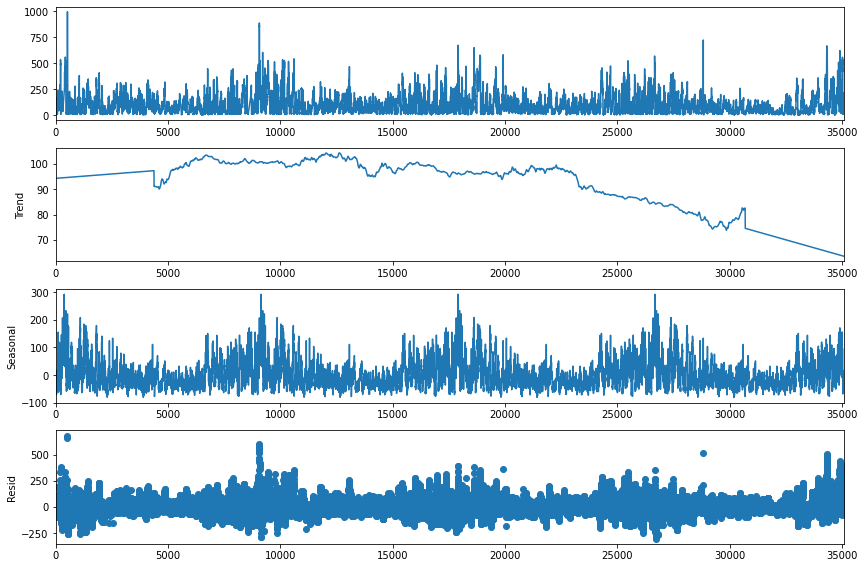

In [4]:
import statsmodels.api as sm

#data指你自己的时序数据，model='additive'代表是加法模式，
#extrapolate_trend='freq'表示trend 、resid频率会从最近点开始，并且会对最近点的缺失值进行填充
#更多参数设置请参考官方文档：https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = sm.tsa.seasonal_decompose(data, model='additive', extrapolate_trend='freq',period=8760)  
plt.rc('figure',figsize=(12,8))
fig = decomposition.plot()
plt.show()

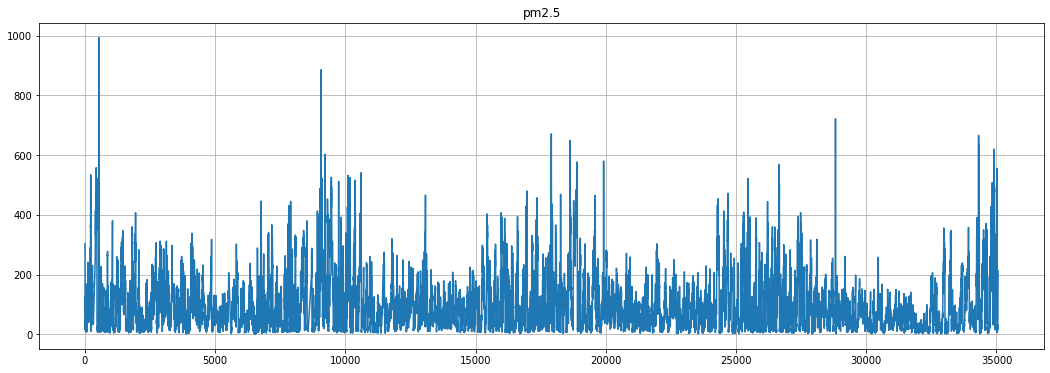

In [5]:
plt.figure(figsize=(18, 6))
plt.plot(data.Value)
plt.title('pm2.5')
plt.grid(True)
plt.show()


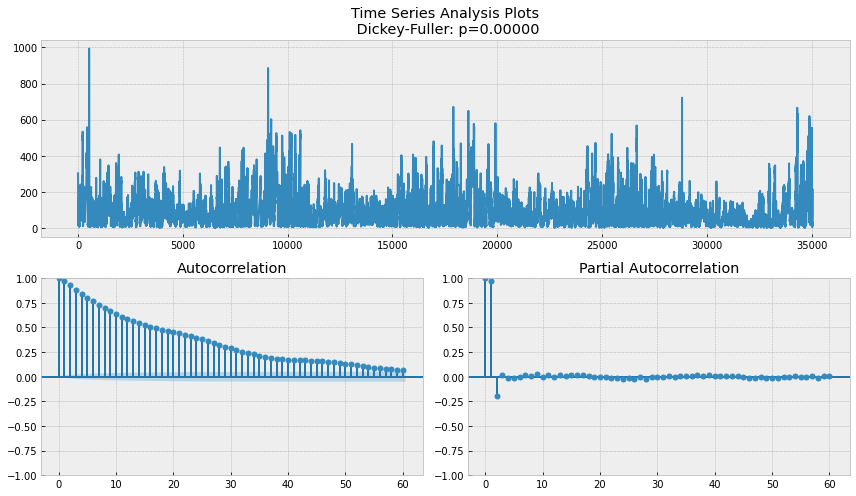

In [6]:
tsplot(data.Value, lags=60)


In [7]:
# The seasonal difference
ads_diff = data.Value - data.Value.shift(8760)
tsplot(ads_diff[8760:], lags=60)


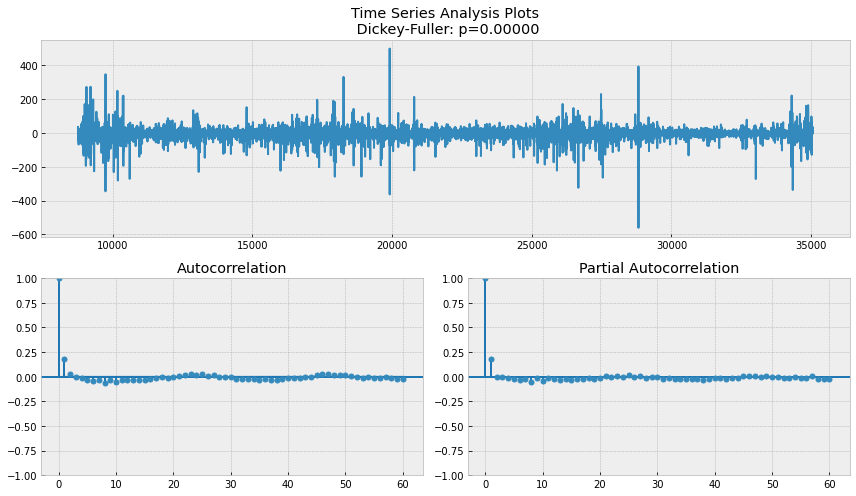

In [ ]:
ads_diff = data.Value - data.Value.shift(1)
tsplot(ads_diff[8760+1:], lags=60)


In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 8760 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  # 36


36

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data.Value, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [ ]:
p, q, P, Q = [2,3,1,1]

best_model=sm.tsa.statespace.SARIMAX(data.Value, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

NameError: name 'sm' is not defined